In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
#GPU指定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# EfficientNet-b0 model のロード
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
#ファインチューニング（全てのパラメータを訓練可能に）
for param in model.parameters():
    param.requires_grad = True  
model = model.to(device)

#モデルの構造確認
print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [3]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/Ki67値クラス分類データセット/train')  
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/Ki67値クラス分類データセット/test') 


#学習用データの前処理
transform = torchvision.transforms.Compose([
    #ランダムな領域を切り取って画像をリサイズ
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調（明るさ，コントラスト）を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    #ピクセル値の正規化
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


#テスト用データの前処理
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#バッチサイズの設定(2の乗数が一般的)
batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

#フォルダのクラス名の表示
print(train_dataset.classes)

['1 Low', '2 High']


In [4]:
#モデルのパラメータ数などの確認
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [5]:
#訓練関数の定義

def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100 
    #Early stoppingにおけるエポック数の設定
    patience = 10
    trigger_times = 0

    #エポック数の設定
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [6]:
#検証関数の定義

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)

In [7]:
#テスト関数の定義

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels.numpy())
            predicts_list.append(predicted.numpy())
            scores_list.append(probs.numpy()) 
    
        labels = np.concatenate(labels_list)
        predicted = np.concatenate(predicts_list)
        scores = np.concatenate(scores_list) 

        fpr, tpr, _ = roc_curve(labels, scores[:, 1]) 
        roc_auc = auc(fpr, tpr)

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, pos_label=1)  
        re = recall_score(labels, predicted, pos_label=1)
        f1 = f1_score(labels, predicted, pos_label=1)
        
        AUC = roc_auc_score(labels, scores[:, 1])  

        print(C)
        print("\n")
        print(f"test accuracy : {ac:.3f}")
        print(f"test precision : {pre:.3f}")
        print(f"test recall : {re:.3f}")
        print(f"test F1 : {f1:.3f}")
        print(f"AUC : {AUC:.3f}")

        print("AUC for the positive class: {:.3f}".format(roc_auc))

        
        #ROC曲線図の作成
        plt.plot(fpr, tpr,
             label='ROC curve (area = {:.3g})'
                   ''.format(roc_auc),
             color='navy', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        #混同行列図のクラス名の設定
        class_labels = ['low-value', 'high-value']
        C = confusion_matrix(labels, predicted)

        
        #混同行列図の作成
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()


In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Loaded pretrained weights for efficientnet-b0
Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.511 acc: 74.207
The current loss: 0.5393127468837933
trigger times: 0
[[387  93]
 [137 103]]


test accuracy : 0.681
test precision : 0.526
test recall : 0.429
test F1 : 0.472
AUC : 0.703
AUC for the positive class: 0.703


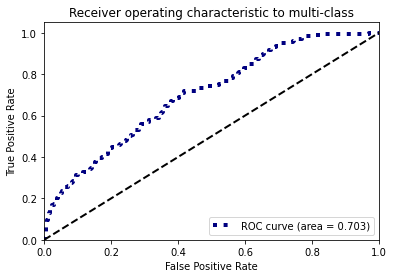

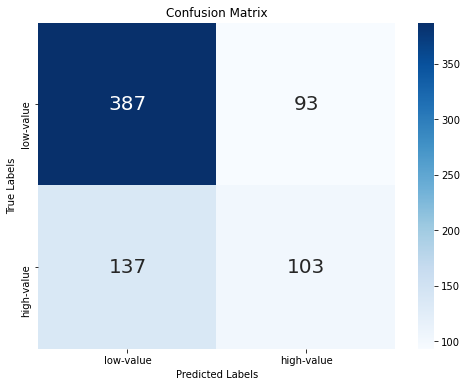

Loaded pretrained weights for efficientnet-b0
Fold 2------------------------------------------------------------------------------


KeyboardInterrupt: 

In [9]:
#プログラムの実行時間の算出
%%time


#main関数
def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        #交差検証に伴う使用モデルの再定義
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
       
        for param in model.parameters():
            param.requires_grad = True  
        model = model.to(device)


        batch_size = 32
        #損失関数の定義
        criterion = nn.CrossEntropyLoss()
        #最適化関数の定義
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
        
        #交差検証に伴うデータセットの分割
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        #パラメータの保存
        torch.save(model.state_dict(), 'sample_' + str(_fold) + '.pt')
        #test関数の実行
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()